In [15]:
# Run this cell first
import os
import numpy as np
import librosa
import random
from glob import glob
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dropout, Dense, Bidirectional, LSTM, BatchNormalization, Flatten
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

In [16]:
sr = 22050
clip_duration = 10   # seconds (change to 5 to generate more clips)
n_mfcc = 40
n_fft = 2048
hop_length = 512

In [17]:
SR = 22050
CLIP_DURATION = 10
CLIP_SAMPLES = SR * CLIP_DURATION
N_MFCC = 40
N_FFT = 2048
HOP_LENGTH = 512

def extract_mfcc_from_clip(clip, sr=SR, n_mfcc=N_MFCC, n_fft=N_FFT, hop_length=HOP_LENGTH):
    """
    Input: raw audio clip (1D numpy) of exact length CLIP_SAMPLES
    Returns: mfcc (timesteps, n_mfcc) padded/truncated to expected_frames
    """
    mfcc = librosa.feature.mfcc(y=clip, sr=sr, n_mfcc=n_mfcc, n_fft=n_fft, hop_length=hop_length)
    mfcc = mfcc.T  # shape (timesteps, n_mfcc)
    # Compute expected frames from clip length:
    expected_frames = 1 + (CLIP_SAMPLES - n_fft) // hop_length
    if mfcc.shape[0] < expected_frames:
        pad_width = expected_frames - mfcc.shape[0]
        mfcc = np.pad(mfcc, ((0, pad_width),(0,0)), mode='constant')
    elif mfcc.shape[0] > expected_frames:
        mfcc = mfcc[:expected_frames, :]
    return mfcc  # (expected_frames, n_mfcc)


In [18]:
def prepare_dataset(dataset_path, genres, sr=SR, clip_samples=CLIP_SAMPLES):
    X = []
    labels = []
    for genre in genres:
        files = glob(os.path.join(dataset_path, genre, "*"))
        for fpath in files:
            try:
                # librosa.load will use audioread for mp3 if soundfile fails; use raw string for Windows paths
                signal, _ = librosa.load(fpath, sr=sr)
            except Exception as e:
                print("Failed to load", fpath, e)
                continue

            # slice into full clips only
            for start in range(0, len(signal), clip_samples):
                clip = signal[start:start+clip_samples]
                if len(clip) == clip_samples:
                    mfcc = extract_mfcc_from_clip(clip)
                    X.append(mfcc)
                    labels.append(genre)
    X = np.array(X)  # shape (samples, timesteps, n_mfcc)
    return X, np.array(labels)

# Example call:
DATASET_PATH = r"C:\Users\USER\Desktop\Song_dataset"   # your folder with 'rap' and 'melody' subfolders
genres = ["rap", "melody"]
X, labels = prepare_dataset(DATASET_PATH, genres)
print("X shape:", X.shape)  # e.g., (num_clips, 427, 40)


X shape: (993, 427, 40)


In [19]:
# Encode
le = LabelEncoder()
y_int = le.fit_transform(labels)   # rap -> 0, melody -> 1 (example)
y = to_categorical(y_int)

# Train-test split (stratify to keep class balance)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y_int)

print("Train shape:", X_train.shape, y_train.shape)
print("Test shape:", X_test.shape, y_test.shape)


Train shape: (794, 427, 40) (794, 2)
Test shape: (199, 427, 40) (199, 2)


In [20]:
def build_cnn_lstm(input_shape, n_classes):
    model = Sequential()
    # Conv block 1
    model.add(Conv1D(filters=64, kernel_size=3, padding='same', activation='relu', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.25))

    # Conv block 2
    model.add(Conv1D(filters=128, kernel_size=3, padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.25))

    # Optionally more conv blocks can be added

    # LSTM part: use Bidirectional for better context
    model.add(Bidirectional(LSTM(128, return_sequences=False)))
    model.add(Dropout(0.3))

    # Dense head
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(n_classes, activation='softmax'))

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

input_shape = (X_train.shape[1], X_train.shape[2])
model = build_cnn_lstm(input_shape, n_classes=y.shape[1])
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 427, 64)           7744      
                                                                 
 batch_normalization (BatchN  (None, 427, 64)          256       
 ormalization)                                                   
                                                                 
 max_pooling1d (MaxPooling1D  (None, 213, 64)          0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 213, 64)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 213, 128)          24704     
                                                                 
 batch_normalization_1 (Batc  (None, 213, 128)         5

In [21]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True),
    ModelCheckpoint('best_cnn_lstm.h5', monitor='val_loss', save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
]

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=25,          # reduced epochs to avoid overfitting
    batch_size=8,
    callbacks=callbacks
)


Epoch 1/25
100/100 [==============================] - 14s 91ms/step - loss: 0.4534 - accuracy: 0.7809 - val_loss: 0.1572 - val_accuracy: 0.9598 - lr: 0.0010
Epoch 2/25
100/100 [==============================] - 7s 75ms/step - loss: 0.2482 - accuracy: 0.9018 - val_loss: 0.1248 - val_accuracy: 0.9497 - lr: 0.0010
Epoch 3/25
100/100 [==============================] - 8s 79ms/step - loss: 0.1960 - accuracy: 0.9270 - val_loss: 0.2021 - val_accuracy: 0.9296 - lr: 0.0010
Epoch 4/25
100/100 [==============================] - 8s 84ms/step - loss: 0.1715 - accuracy: 0.9332 - val_loss: 0.0731 - val_accuracy: 0.9799 - lr: 0.0010
Epoch 5/25
100/100 [==============================] - 8s 76ms/step - loss: 0.1759 - accuracy: 0.9358 - val_loss: 0.1787 - val_accuracy: 0.9246 - lr: 0.0010
Epoch 6/25
100/100 [==============================] - 8s 78ms/step - loss: 0.1342 - accuracy: 0.9509 - val_loss: 0.0712 - val_accuracy: 0.9698 - lr: 0.0010
Epoch 7/25
100/100 [==============================] - 8s 80ms/s

Test loss: 0.0435, Test accuracy: 98.99%
7/7 [==============================] - 1s 49ms/step
              precision    recall  f1-score   support

      melody       1.00      0.98      0.99       108
         rap       0.98      1.00      0.99        91

    accuracy                           0.99       199
   macro avg       0.99      0.99      0.99       199
weighted avg       0.99      0.99      0.99       199

Confusion matrix:
 [[106   2]
 [  0  91]]


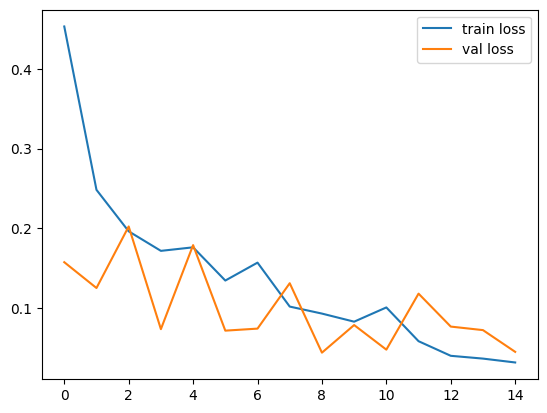

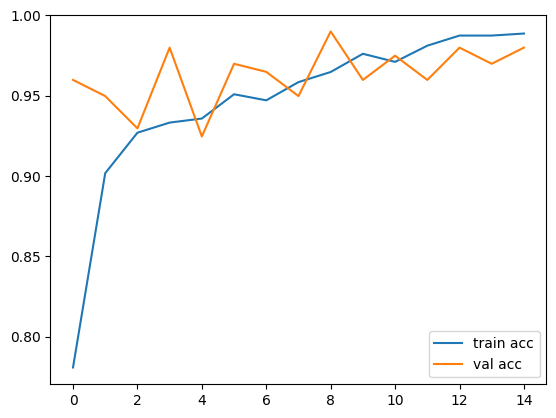

In [22]:
# Evaluate on test set
loss, acc = model.evaluate(X_test, y_test, verbose=0)
print(f"Test loss: {loss:.4f}, Test accuracy: {acc*100:.2f}%")

# Predictions
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

print(classification_report(y_true, y_pred, target_names=le.classes_))
print("Confusion matrix:\n", confusion_matrix(y_true, y_pred))

# Plot training curves
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend(); plt.show()
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend(); plt.show()


In [23]:
model.save('cnn_lstm_model_final.keras')
# later:
# loaded_model = load_model('cnn_lstm_model_final.keras')


In [24]:
def predict_genre_for_song(file_path, model, encoder, sr=SR, clip_duration=CLIP_DURATION):
    clip_samples = sr * clip_duration
    try:
        signal, _ = librosa.load(file_path, sr=sr)
    except Exception as e:
        return {"error": f"Could not load file: {e}"}
    probs = []
    for start in range(0, len(signal), clip_samples):
        clip = signal[start:start+clip_samples]
        if len(clip) == clip_samples:
            mfcc = extract_mfcc_from_clip(clip)
            mfcc = np.expand_dims(mfcc, axis=0)  # (1, timesteps, features)
            p = model.predict(mfcc, verbose=0)[0]  # e.g., [0.1, 0.9]
            probs.append(p)
    if len(probs) == 0:
        return {"error": "Song too short for clip duration"}
    probs = np.array(probs)
    avg_probs = probs.mean(axis=0)
    final_class = np.argmax(avg_probs)
    return {
        "pred_label": encoder.inverse_transform([final_class])[0],
        "avg_probs": avg_probs,
        "per_clip_probs": probs
    }


In [25]:
# Usage (Windows path note: use raw string r"...")
file_path = r"C:\Users\USER\Downloads\Thangapoovey.mp3"
result = predict_genre_for_song(file_path, model, le)
print(result["pred_label"], result["avg_probs"])

melody [0.79503566 0.20496435]


In [26]:
# Usage (Windows path note: use raw string r"...")
file_path = r"C:\Users\USER\Downloads\Powerhouse.mp3"
result = predict_genre_for_song(file_path, model, le)
print(result["pred_label"], result["avg_probs"])

rap [2.0979496e-04 9.9979019e-01]
